## Install package from GitHub

In [5]:
# !pip3 install git+https://github.com/yicjia/CausalDeepCENT.git -q

In [108]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))


/var/folders/38/05rshw150dz6n2rqnqpvq49h0000gp/T/ipykernel_44205/1372205583.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [7]:
# pip list
import sys
!{sys.executable} -m pip install lifelines

In [8]:
# imports for tutorial of wrapped POC model
from CausalDeepCENT import causal_deepcent as cdc
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import DataLoader, TensorDataset
import lifelines

In [9]:
## check device (CPU or GPU)
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

In [10]:
device

device(type='cpu')

In [153]:
# imports for model backend code 

# Scientific computing 
import numpy as np
import pandas as pd

# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()
import matplotlib.pyplot as plt
from IPython.display import clear_output

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as dist


# Propensity Estimator
from sklearn.linear_model import LogisticRegression


# general python
import json
import math
import csv
import os
import time

In [162]:
# model backend code wrapped 

# CausalDeepCENT designed model. 

# 
class Net(nn.Module):
    def __init__(
        self, 
        n_feature, 
        num_layers, 
        node, 
        dropout, 
        drop_factor = 1
    ):
        
        super(Net, self).__init__()
        
        # INPUT LAYERS
        layers = [
            nn.Linear(n_feature, node),
            nn.BatchNorm1d(node),
            nn.ReLU()
        ]
        
        # HIDDEN LAYERS
        node_temp = node
        for i in range(0, num_layers):
            node_temp0 = max(4, int(node_temp / (drop_factor**i)))
            node_temp1 = max(4, int(node_temp0 / drop_factor))
            
            layers += [
                nn.Linear(node_temp0, node_temp1),
                nn.BatchNorm1d(node_temp1),
                nn.ReLU(),
                nn.Dropout(p=dropout) 
            ]
            
        layers += [nn.ReLU()]
        
        
        # OUTPUT LAYER
        layers += [nn.Linear(node_temp1, 1)]
        self.seq = nn.Sequential(*layers) 

    def forward(self, inputs):
        return self.seq(inputs)  

# inverse propensity score weighting
def getIPW(y, x):
    model = LogisticRegression(solver='liblinear').fit(x, y)
    p = model.predict_proba(x)[:, 1]
    w = y/p+(1-y)/(1-p)
    return w

# weighted mse loss accounting for censoring
def weighted_mse_loss(pred, obs, delta, weight, lambda1):
    mse = delta*((pred - obs) ** 2)

    ind = pred < obs
    delta0 = 1 - delta
    p = ind * delta0 * (obs - pred)**2 
    return ((mse+lambda1*p)*weight).mean()

# enable dropout during "inference" (test-set validation)
def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

## Load data

In [224]:
# Dataset: SPECTRUM_OS


# Load Data 
df = pd.read_csv("spectrum_os.csv", sep="\t")

# Format df to match existing column names / values 
df.rename(columns={"t2":"time", "s2":"event"}, inplace=True)
df.drop(["t1","s1"], axis=1, inplace=True)
df.replace({"event":1}, 0, inplace=True)  # not death
df.replace({"event":3}, 1, inplace=True)  # death 

# estimate propensity score via logistic regression
# in a RCT, we know the probability of treatment P(A), but lets allow it to be estimated ... 
df["W"] = 0.5 # cdc.getIPW(df["A"],df[["Z1","Z2","Z3","Z4"]])


# Prepare the data for Training + Testing 
## Split the data into training and test sets

test_size=0.3

train_df, test_df = train_test_split(df, test_size=test_size,random_state=2)
train_df


# TRAIN 
X_train = train_df.drop(["time","event","W", "id"], axis = 1)
NUM_FEATURES = X_train.shape[1]

# save vars for post-prediction inference
y_train = np.log(train_df["time"])
E_train = train_df["event"]
W_train = train_df["W"]


# TEST 
# save vars for post-prediction inference
X_test = test_df.drop(["time","event","W", "id"], axis = 1)
y_test = np.log(test_df["time"])
E_test = test_df["event"]

# PRE-PROCESS: NORMALIZE VARIABLES    
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# FORMAT DATA to TENSOR  
# TRAIN  
X_train, y_train, E_train, W_train = (
    np.array(X_train), 
    np.array(y_train), 
    np.array(E_train), 
    np.array(W_train)
)

train_dataset = TensorDataset(
    torch.from_numpy(X_train).float().to(device), 
    torch.from_numpy(y_train).float().to(device), 
    torch.from_numpy(E_train).float().to(device), 
    torch.from_numpy(W_train).float().to(device)
)

# TEST
X_test, y_test, E_test = (
    np.array(X_test), 
    np.array(y_test), 
    np.array(E_test)
)

# why do not include the weights here ? 
test_dataset = TensorDataset(
    torch.from_numpy(X_test).float().to(device), 
    torch.from_numpy(y_test).float().to(device), 
    torch.from_numpy(E_test).float().to(device)
)

In [164]:
# debug view: X_test 
train_df.drop(["time","event","W", "id"], axis = 1)  #X_train

,Z1,Z2,Z3,Z4,A
113,0.232692,0,1,1,1
220,7.232692,1,1,0,1
140,13.232692,0,1,1,-1
210,1.232692,1,1,0,-1
133,2.232692,1,0,0,-1
...,...,...,...,...,...
75,1.232692,1,1,0,-1
466,-5.767308,1,1,0,-1
299,-3.767308,1,0,0,-1
493,-5.767308,1,0,0,1


# Tuning Model 

In [227]:

# Structure 
subdir = "./simulation_results/"
experiment_name = "spectrum_tuning_01_results"


# HYPERPARAMETERS
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NODE = NUM_FEATURES  # 32 # 128 
NUM_LAYER = 3
LAMBDA1 = 0.01
DROPOUT = 0.8

def Causal_DeepCENT(
    train_dataset,
    test_dataset,
    num_feature = NUM_FEATURES,
    num_layers = NUM_LAYER, # model complexity
    node = NODE, 
    dropout = DROPOUT, # information retention per batch 
    lr = LEARNING_RATE, 
    batch_size = BATCH_SIZE, # batch back-propogation
    num_epoch = EPOCHS,
    lambda1 = LAMBDA1, # DeepCENT MSE Regularisation parameter (?) 
    T=100, # Dropout Uncertainty Repetitions per predictions 
    seed = 123,
    plot = True
):

    # save hyperparameters to file 
    hyperparameters = {
        "seed ": 123,
        "T":100,
        "num_feature ": NUM_FEATURES,
        "num_layers ": NUM_LAYER,
        "node ": NODE ,
        "dropout ": DROPOUT,
        "lr ": LEARNING_RATE,
        "batch_size ": BATCH_SIZE,
        "num_epoch ": EPOCHS,
        "lambda1 ": LAMBDA1
    }

    if plot:
        subdir = "./simulation_results/"
        experiment_name = "spectrum_tuning_02"
        with open(subdir + experiment_name+".json", "w") as out_file:
            json.dump(hyperparameters, out_file, indent=4)
            
            
        

    # INITIALIZE MODEL 
    torch.manual_seed(seed)
    model = Net(
        n_feature=num_feature, 
        num_layers = num_layers, 
        node=node, 
        dropout=dropout
    )
    model.to(device)


    # choose optimizer 
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-8)

    # Train 
    train_loader = DataLoader(
        dataset=train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        drop_last=True
    )

    # Prediction of single-batch on the test set 
    test_loader = DataLoader(
        dataset=test_dataset, 
        batch_size=len(test_dataset)
    )

    # for X_batch, lala, koko in test_loader:
    #     print(X_batch)


    # TRAINING 
    epoch_loss_train = []
    epoch_loss_test = []

    if plot:
        # plotting train / test loss per epoch 
        fig, ax = plt.subplots(figsize=(10, 5))

    for e in range(1, num_epoch+1):
        # print("EPOCH", e)
        model.train() # turn on some specific layers/parts of the model during model training

        # train in batches 
        for X_train_batch, y_train_batch, E_train_batch, W_train_batch in train_loader:

            # Resets the gradients of all optimized torch.Tensors
            optimizer.zero_grad()

            # predict 
            y_train_pred = model(X_train_batch)

            # Calculate Loss 
            mseloss = weighted_mse_loss(
                y_train_pred, 
                y_train_batch.unsqueeze(1), 
                E_train_batch.unsqueeze(1), 
                W_train_batch.unsqueeze(1),
                lambda1
            )

            # Save Loss for plotting 
            # print(mseloss.detach().numpy())
            epoch_loss_train += [mseloss.detach().numpy()]

            # Back-Propogation
            train_loss = mseloss 
            train_loss.backward()
            optimizer.step()

        #######################################
        # PREDICT ON TEST SET EACH EPOCH 
        # TO VISUALIZE TEST/TRAIN Generalization Gap 
        #######################################

        # Do not backpropogate the error during test prediction. 
        with torch.no_grad():

            # turn on model evaluation mode
            model.eval()  
            enable_dropout(model)

            result = []
            epoch_test_losses = []

            # Bayesian Approximation using output-layer-dropout        
            # predict T=100 times with dropout 
            for _ in range(T): 
                y_pred_list = [] 
                for X_batch, y_test_batch, E_test_batch in test_loader:

                    # predict on batch 
                    y_test_pred = model(X_batch)
                    y_pred_list.append(y_test_pred.cpu().numpy())
                    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
                    if len(y_pred_list)>1: y_pred_list = sum(y_pred_list, [])

                    # How to compute the loss on the test set ? 
                    # Compute propensity score weights ? 
                    # weighted_mse_loss(pred, obs, delta, weight, lambda1) 
                    test_mseloss = weighted_mse_loss(
                        pred = y_test_pred, 
                        obs = y_test_batch.unsqueeze(1), 
                        delta = E_test_batch.unsqueeze(1),
                        weight = 0.5, 
                        lambda1 = lambda1
                    ).detach().numpy()

                    # plot losses over batches/epochs
                    epoch_test_losses.append(test_mseloss)

                result.append(y_pred_list)

            result = np.array(result)
    #         print("EPOCH TEST RESULT")
    #         print(result)

            epoch_loss_test += [np.mean(epoch_test_losses)]

    #     np.repeat(np.mean(epoch_test_losses), len(test_loader)).tolist()
    #         print(epoch_loss_test)
    #         epoch_loss_test_x_axis += [e]


            # Bayesian Approximation using dropout on Output Layer during inference for  
            y_test_pred_mean = result.mean(axis=0).reshape(-1,)
            y_test_pred_sd = result.std(axis=0).reshape(-1,)

            ## Question: Is the Normal Distribution appropriate ? 
            # y_test_pred_upper = y_test_pred_mean + 1.96*y_test_pred_sd
            # y_test_pred_lower = y_test_pred_mean - 1.96*y_test_pred_sd
        #######################################



    if plot:
        #######################################
        # PLOT TRAIN / TEST LOSSES 
        #######################################

        # https://stackoverflow.com/questions/21360361/how-to-dynamically-update-a-plot-in-a-loop-in-ipython-notebook-within-one-cell
        # plt.clf()
        #     fig.canvas.flush_events()
        #     clear_output(wait=True)
        #     ax.cla() 

        # print(epoch_loss_train)    
        ax.cla()
        ax.plot(epoch_loss_train[0::len(train_loader)], label="TRAIN")
        ax.plot(epoch_loss_test,  label="TEST")
        ax.set_xlabel("Epoch Batch")
        ax.set_ylabel("MSE-Loss")
        ax.set_title("Training Loss")
        ax.legend()

        display(fig)
        clear_output(wait=True)
        plt.pause(0.1)

        fig.savefig(fname=subdir+experiment_name+"_train_loss.jpg")


        # SAVE to FILE 
        #     fig1 = plt.gcf()
        #     plt.show()
        #     plt.draw()




    ##########################
    # EVALUATION ON TEST SET #
    ##########################

    # Do not backpropogate the error during test prediction. 
    with torch.no_grad():

        ###################################################################################    
        model.eval()  
        # model.eval(): turn off some specific layers/parts of the model during model evaluation,
        # because they behave differently during training and inference (i.e. validation). 
        # E.G. Dropouts Layers, BatchNorm Layers etc.     

        # # turn back to training mode after eval step with `model.train()`

        # enable dropout 
        enable_dropout(model)
        ###################################################################################
        # https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
        ###################################################################################

        # Bayesian 
        result = []
        for _ in range(T): 
            y_pred_list = [] 
            for X_batch, y_test_batch, E_test_batch in test_loader:

                # predict on batch 
                y_test_pred = model(X_batch)
                y_pred_list.append(y_test_pred.cpu().numpy())
                y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
                if len(y_pred_list)>1: y_pred_list = sum(y_pred_list, [])

                # How to compute the loss on the test set ? 
                # Compute propensity score weights ? 
                # weighted_mse_loss(pred, obs, delta, weight, lambda1) 
                test_mseloss = weighted_mse_loss(
                    pred = y_test_pred, 
                    obs = y_test_batch.unsqueeze(1), 
                    delta = E_test_batch.unsqueeze(1),
                    weight = 0.5, 
                    lambda1 = lambda1
                ).detach().numpy()

            result.append(y_pred_list)

        result = np.array(result)

        # Bayesian Approximation using dropout on Output Layer during inference for  
        y_test_pred_mean = result.mean(axis=0).reshape(-1,)
        y_test_pred_sd = result.std(axis=0).reshape(-1,)

        ## Question: Is the Normal Distribution appropriate ? 
        y_test_pred_upper = y_test_pred_mean + 1.96*y_test_pred_sd
        y_test_pred_lower = y_test_pred_mean - 1.96*y_test_pred_sd


    # return y_test_pred_mean,y_pred_list_upper, y_pred_list_lower

    ##########################################
    # Format Output the prediction on test set
    ##########################################
    test_predictions = pd.DataFrame(
        list(
            zip(
                test_df["time"],
                test_df['event'],
                test_df['Z1'],
                np.exp(y_test_pred_mean), 
                np.exp(y_test_pred_lower), 
                np.exp(y_test_pred_upper))
        ),
        columns=['time', 'event', 'Z1', 'pred_time','pred_time_lower','pred_time_upper']
    )

    if plot:
        ##########################################
        # save model prediction output to file 
        ##########################################
        with open(subdir + experiment_name+ "_predictions.csv", "w") as fn:
            test_predictions.to_csv(fn)

        # SAVE TRAIN/TEST LOGS 
        SIM_RESULTS = {
            "TRAINING_LOSS": epoch_loss_train[-1],
            "VALIDATION_LOSS": 0
        }
        with open(subdir + experiment_name+".json", "w") as out_file:
            json.dump(hyperparameters, out_file, indent=4)


        ############################################
        # Predictive Diagnostic for Survival Models 
        ############################################
        # - MSE doesn't work 
        # - Schoenfield Residuals 
        # - Martingale Residuals 
        # - 

        #########################    
        #### Plotting MSE 
        # Doesn't really work for Censored Survival data. Need to be on the proper scale. 
        #########################
        fig, ax = plt.subplots(figsize=(10, 5))

        # Predicted vs Actual (color by Censored status)
        sns.scatterplot(
            test_predictions, 
            x="time", 
            y="pred_time", 
            hue='event',
            alpha=0.5,
            ax = ax
        )

        # print("AHAHAHA", test_predictions['pred_time'].max())
        # print("AHAHAHA", test_predictions['time'].max())

        # # Diagonal Line 
        # lala = max(test_predictions['pred_time_exp'].max(), test_predictions['time'].max())
        # diag_x = [0, lala]
        # diag_y = [0, lala]
        # print(diag_x)
        # print(diag_y)
        # sns.lineplot(x=diag_x,y=diag_y, ax=ax )

        fig1 = plt.gcf()
        plt.show()
        plt.draw()
        fig1.savefig(fname=subdir+experiment_name+"_predicted_residuals.jpg")

        ##################
        # Survival curves 
        ##################
        # Validation Set: True Data vs Predicted Data 

        kmf = lifelines.KaplanMeierFitter()

        kmf.fit(test_predictions['time'],test_predictions['event'], label="actual")
        ax = kmf.plot_survival_function()

        kmf.fit(test_predictions['pred_time'],test_predictions['event'], label="predicted")
        ax = kmf.plot_survival_function(ax=ax)


        # ax.get_figure().savefig("./../../sim_results/causaldeepcent_predicted_survival_curves.png")
        # ax.get_figure().savefig("./../../documents/thesis_paper/diagrams/causaldeepcent_predicted_survival_curves.png")




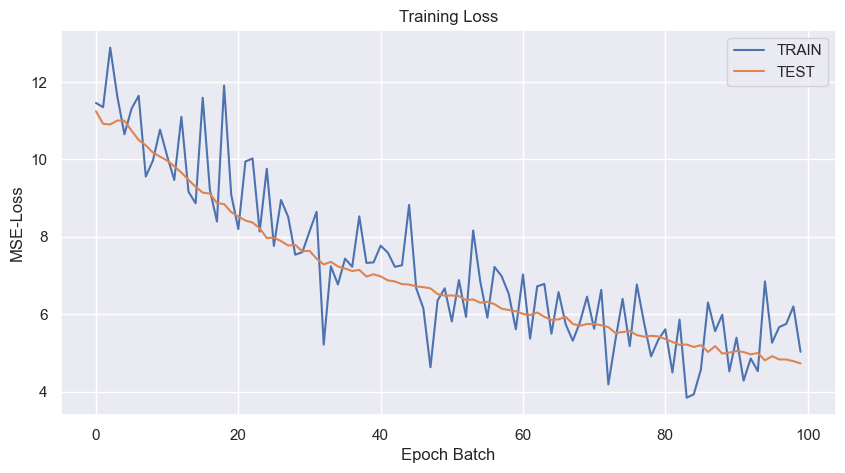

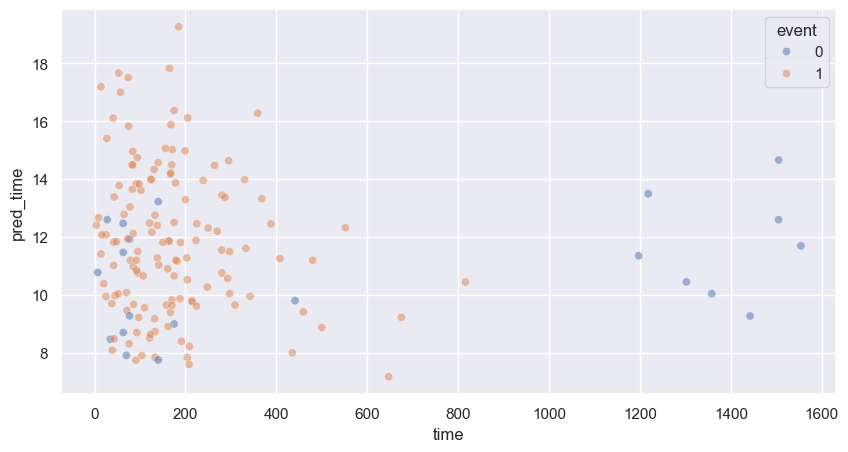

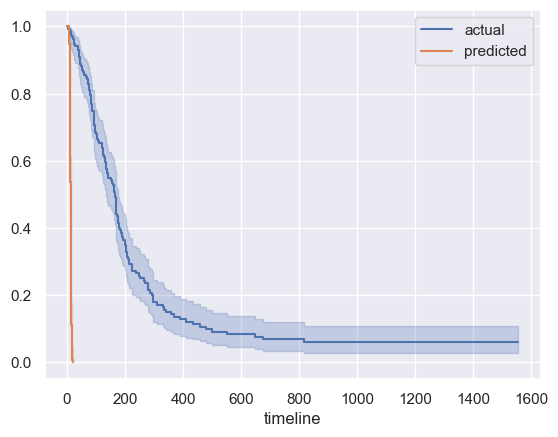

In [228]:
Causal_DeepCENT(
    train_dataset,
    test_dataset,
    num_feature = NUM_FEATURES,
    num_layers = NUM_LAYER, # model complexity
    node = NODE, 
    dropout = DROPOUT, # information retention per batch 
    lr = LEARNING_RATE, 
    batch_size = BATCH_SIZE, # batch back-propogation
    num_epoch = EPOCHS,
    lambda1 = LAMBDA1, # DeepCENT MSE Regularisation parameter (?) 
    T=100, # Dropout Uncertainty Repetitions per predictions 
    seed = 123,
    plot = True
)


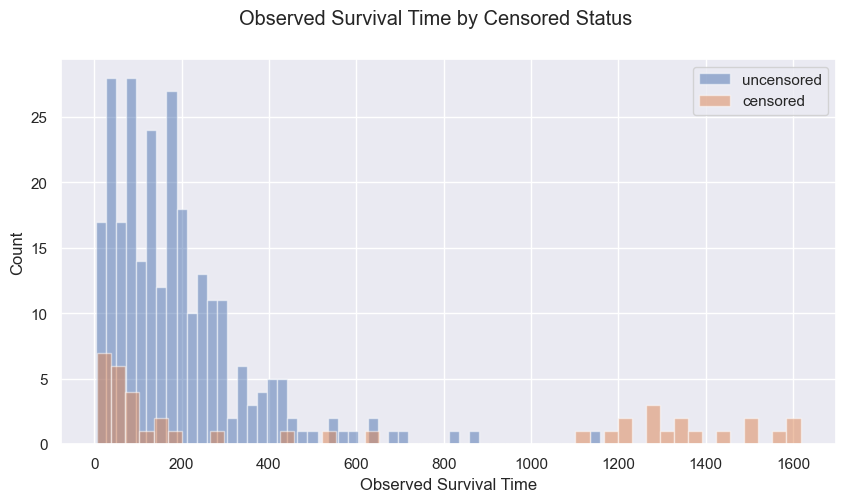

AttributeError: 'Axes' object has no attribute 'xlabel'

<Figure size 640x480 with 0 Axes>

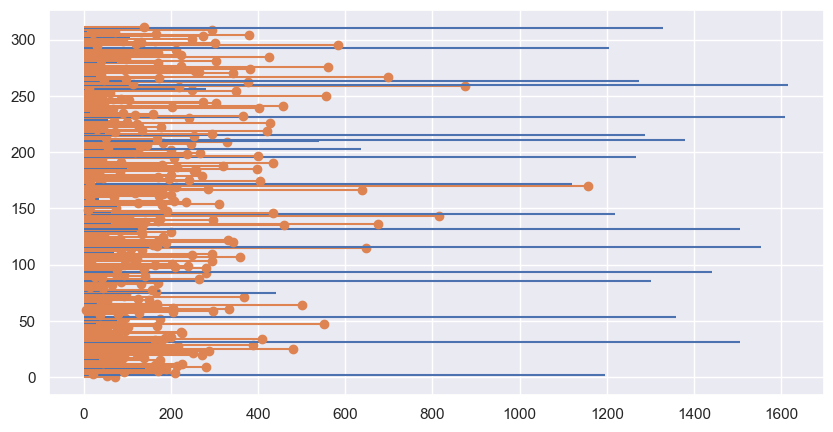

In [223]:
# censored times 


### Observed Survival Time Histograms 
# fig, (ax1, ax2) = plt.subplots(2, 1)
fig, ax = plt.subplots(figsize=(10, 5))

plt.hist(
    test_predictions[test_predictions['event']==1]['time'], 
    alpha=0.5,
    label="uncensored",
    bins=50
)
plt.hist(
    test_predictions[test_predictions['event']==0]['time'], 
    alpha=0.5,
    label="censored",
    bins=50
)
ax.set_ylabel("Count")
ax.set_xlabel("Observed Survival Time")
fig.suptitle("Observed Survival Time by Censored Status")
ax.legend()

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(fname=subdir+experiment_name+"_censoring_distribution.jpg")




###### life-lines 
def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    
    fig, ax = plt.subplots(figsize=(10, 5))

    for y, row in obs.iterrows():
        start = 0
        end = row['time']
        status = row['event']
        
        if status == 0:
            # ongoing
            plt.hlines(y, start, end, color='C0')
        else:
            # complete
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
            
    ax.xlabel('Time (weeks)')
    ax.ylabel('Dog index')
    ax.legend()
    plt.gca().invert_yaxis()
    
    
plot_lifelines(test_predictions)

In [234]:

### Exhaustive Grid-Search HyperParameter Tuning 
grid_search = {
    "num_layers ": range(1,10),
    "node ": range(1,1000, 10),
    "dropout ": np.arange(0,1,0.1),
    "lr ": np.arange(1e-6,1e-1,(1e-1-1e-6)/10),
    "batch_size ": 2** np.arange(8),
    "lambda1 ": np.arange(0.01,0.5,0.02)
}

total_configurations = sum([len(v) for k,v in grid_search.items()])
print(total_configurations)


for c_layer in grid_search['num_layers']:
    for c_node in grid_search['node']:
        for c_dropouts in grid_search['dropout']:
            for c_lr in grid_search['lr']:
                for c_batch_size in grid_search['batch_size']:
                    for c_lambda1 in grid_search['lambda1']:
                        Causal_DeepCENT(
                            train_dataset,
                            test_dataset,
                            num_feature = NUM_FEATURES,
                            num_layers = c_layer, # model complexity
                            node = c_node, 
                            dropout = c_dropout, # information retention per batch 
                            lr = c_lr, 
                            batch_size = c_batch_size, # batch back-propogation
                            num_epoch = EPOCHS,
                            lambda1 = c_lambda1, # DeepCENT MSE Regularisation parameter (?) 
                            T=100, # Dropout Uncertainty Repetitions per predictions 
                            seed = 123,
                            plot = False
                        )

162


KeyError: 'num_layers'

218
index_start 1
index_start 11
index_start 21
index_start 31
index_start 41
index_start 51
index_start 61
index_start 71
index_start 81
index_start 91
index_start 101
index_start 111
index_start 121
index_start 131
index_start 141
index_start 151
index_start 161
index_start 171
index_start 181
index_start 191
index_start 201
index_start 211
index_start 221


{
    7.0: [
        5.592067040366167,
        5.955625337605026,
        4.979344911619717,
        4.29410039071337,
        3.4990812308291757,
        4.5606400289930455,
        4.781279806197241,
        5.250251425604987,
        4.471372234761724,
        4.503497483406667
    ],
    25.0: [
        5.853619323169313,
        5.852195177107702,
        4.068260561092656,
        4.936684765093335,
        4.083617696447997,
        4.695483088519324,
        5.447975090888794,
        5.155562738661345,
        4.68006246767357,
        6.370021608969715
    ],
    42.0: [
        3.469185254881432,
        6.006506800590844,
        5.266918593656676,
        5.253675633758105,
        4.625510894455749,
        3.9941298789235415,
        5.851403952630308,
        4.344009714874817,
        4.45043865174012,
        4.7943473573013105
    ],
    53.0: [
        5.02155455692078,
        6.242452019677693,
        5.292675021664312,
        6.006733398374398,
        5.721808129416285,
        6.649125563035884,
        4.732837466505662,
        6.193182973396796,
        4.551247633888571,
        6.268413704241183
    ],
    69.0: [
        3.9112155517628784,
        4.804218503829353,
        4.978233396492242,
        6.291475935053575,
        4.403367193361929,
        4.756892185552222,
        3.815617721304033,
        5.769312826828051,
        5.176460917332292,
        4.95565409661891
    ],
    79.0: [
        5.223748187400967,
        4.462321564603504,
        4.591257925596988,
        4.551961974606439,
        5.631995790775959,
        5.005747541924675,
        7.570996588960924,
        4.10391814874967,
        6.38006231310603,
        3.2983434415383592
    ],
    94.0: [
        4.336226283646858,
        5.599657236327409,
        5.69195092774168,
        3.8947152853626865,
        4.957962180919993,
        6.143204606502067,
        6.428195682117072,
        4.596357314457079,
        4.951346685605234,
        7.575495547805248
    ],
    113.0: [
        4.10229341365896,
        4.5676179583583165,
        3.7140133199053635,
        6.562949144846442,
        4.3029556140512,
        5.0258339647320085,
        3.897499166293538,
        4.607316660891227,
        3.651067074437029,
        4.75810983009042
    ],
    129.0: [
        4.408929884191493,
        4.0976141360978175,
        4.262594064636231,
        7.434905397315097,
        4.226033837021612,
        4.1672172734552,
        6.1964601697146104,
        5.353865584986937,
        3.8925543899997908,
        4.679247606769672
    ],
    150.0: [
        4.196923611280157,
        3.9086136987956386,
        4.617372659446238,
        3.6677386052652046,
        4.534230760200467,
        4.773571812335175,
        3.3821290860450315,
        4.015589629398247,
        5.8541047823709595,
        3.7249306975716925
    ],
    169.0: [
        4.2595851029750715,
        4.6510174990460005,
        4.792710842637416,
        3.415863628400834,
        4.819561118830974,
        4.71708929808497,
        4.2056723046931985,
        3.545968869007215,
        4.247139223777238,
        4.415123228120449
    ],
    181.0: [
        7.694629268482901,
        4.0357392781954715,
        5.494266363551975,
        6.238672313910563,
        5.027242869392532,
        4.994970901825517,
        4.532237912361378,
        4.407788914994744,
        5.407381283001625,
        8.488777095747523
    ],
    203.0: [
        3.6153106206471057,
        5.016273835881989,
        5.619671624534704,
        4.627799781121291,
        5.347647360829563,
        4.213327690492817,
        5.056726216572464,
        4.820621462052146,
        4.2534596813209005,
        4.5536117965302765
    ],
    218.0: [
        5.797976480900501,
        4.531016484800527,
        4.789846273623154,
        3.8690429400093165,
        5.5576233407719435,
        5.047203917816472,
        3.9918125860524944,
        5.304430791699631,
       

TypeError: Axes.errorbar() missing 1 required positional argument: 'y'

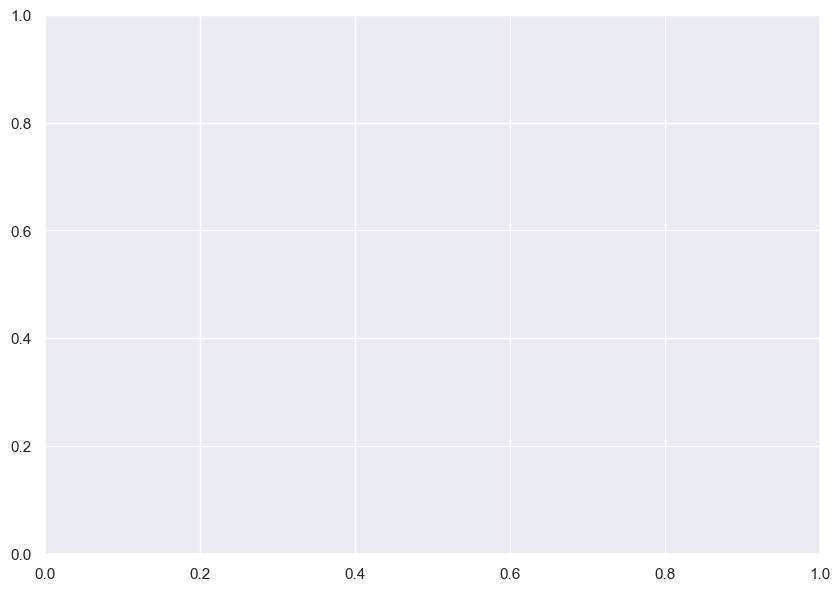

In [220]:


# PLOT THE BAYESIAN APPROXIMATION UNCERTAINTY

# # plot mean and uncertainty
# plt.plot(test_predictions['Z1'], test_predictions['time'], 'or')
# plt.plot(test_predictions['Z1'], test_predictions['pred_time'], 'gray')

# # plot two std (95% confidence)
# plt.fill_between(
#     test_predictions['Z1'], 
#     y_test_pred_upper, 
#     y_test_pred_lower,
#     color='lightblue', 
#     alpha=0.5
# ) 

# # How to One-Hot Encode The Patient Covariates ? 


#### BIN BY COUNT. 
# how to show the range in binned X's and Error Bars of Predicted Y's ? 
# Two-Dimensional box plot ? 


# from rich import print as rprint

# predictions = {row['time']:row['pred_time'] for i, row in test_predictions.iterrows()}

# # 
# predictions_sorted_tuples = sorted(predictions.items())

# # bin by 10 

# bin_size = 10
# index_start = 1
# # for i in range(1,len(predictions)/bin_size):
# print(len(predictions_sorted_tuples))

# binned_data = {}
# while 1 == 1 : 
    
#     print("index_start", index_start)
#     if index_start  >= len(predictions_sorted_tuples):
#         break

#     index_end = min(index_start+10, len(predictions_sorted_tuples))
    
#     x_bin_min = min([x[0] for x in predictions_sorted_tuples[index_start:index_end]])
#     # weight the average by the sd ? 
#     y_bin = [x[1] for x in predictions_sorted_tuples[index_start:index_end]] 
#     binned_data[x_bin_min] = y_bin
    
#     index_start += 10

# rprint(binned_data)
    
# fig, ax = plt.subplots(figsize=(10,7))
# # ax = fig.add_axes([0,0,1,1])
# bp = ax.errorbar(binned_data)
# plt.show()





In [ ]:
help(zip)